In [5]:
!git clone https://github.com/HakanAkkurt/AI-for-Self-Driving-Cars

Cloning into 'AI-for-Self-Driving-Cars'...
remote: Enumerating objects: 19016, done.
remote: Counting objects: 100% (19016/19016), done.
remote: Compressing objects: 100% (18996/18996), done.
remote: Total 19016 (delta 38), reused 18992 (delta 18), pack-reused 0
Receiving objects: 100% (19016/19016), 308.57 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (18950/18950), done.


In [118]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [131]:
data_directory = '/content/AI-for-Self-Driving-Cars/TrainingsData'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_directory, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_680.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_680.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_680.jpg,0.0,0.0,0,0.000078
1,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_783.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_783.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_783.jpg,0.0,0.0,0,0.000078
2,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_884.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_884.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_884.jpg,0.0,0.0,0,0.000078
3,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_19_985.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_19_985.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_19_985.jpg,0.0,0.0,0,0.000080
4,C:\Users\Hakan\Desktop\TrainingsData\IMG\center_2021_09_28_02_03_20_086.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\left_2021_09_28_02_03_20_086.jpg,C:\Users\Hakan\Desktop\TrainingsData\IMG\right_2021_09_28_02_03_20_086.jpg,0.0,0.0,0,0.000078


In [132]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_09_28_02_03_19_680.jpg,left_2021_09_28_02_03_19_680.jpg,right_2021_09_28_02_03_19_680.jpg,0.0,0.0,0,0.000078
1,center_2021_09_28_02_03_19_783.jpg,left_2021_09_28_02_03_19_783.jpg,right_2021_09_28_02_03_19_783.jpg,0.0,0.0,0,0.000078
2,center_2021_09_28_02_03_19_884.jpg,left_2021_09_28_02_03_19_884.jpg,right_2021_09_28_02_03_19_884.jpg,0.0,0.0,0,0.000078
3,center_2021_09_28_02_03_19_985.jpg,left_2021_09_28_02_03_19_985.jpg,right_2021_09_28_02_03_19_985.jpg,0.0,0.0,0,0.000080
4,center_2021_09_28_02_03_20_086.jpg,left_2021_09_28_02_03_20_086.jpg,right_2021_09_28_02_03_20_086.jpg,0.0,0.0,0,0.000078


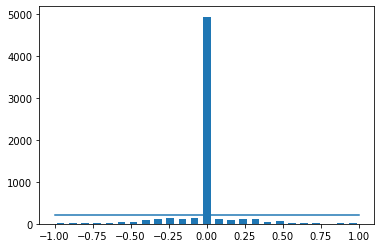

In [133]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6308
removed: 4734
remaining: 1574


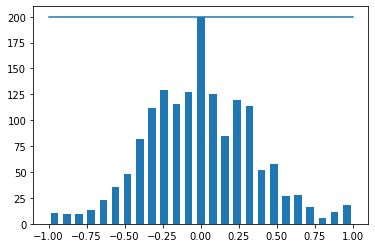

In [134]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [135]:
print(data.iloc[1])
def load_img_steering(data_directory, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(data_directory, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(data_directory + '/IMG', data)

center      center_2021_09_28_02_03_21_308.jpg
left        left_2021_09_28_02_03_21_308.jpg  
right       right_2021_09_28_02_03_21_308.jpg 
steering   -0.535097                          
throttle    1                                 
reverse     0                                 
speed       2.43993                           
Name: 16, dtype: object


In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1259
Valid Samples: 315


Text(0.5, 1.0, 'Validation set')

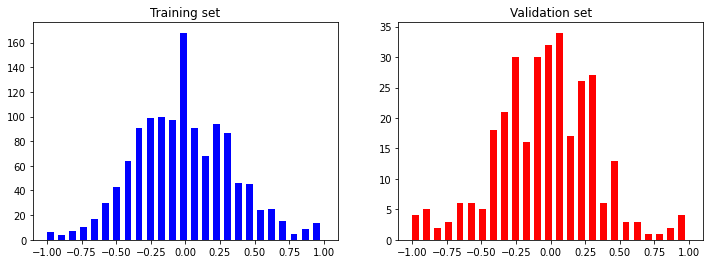

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [138]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

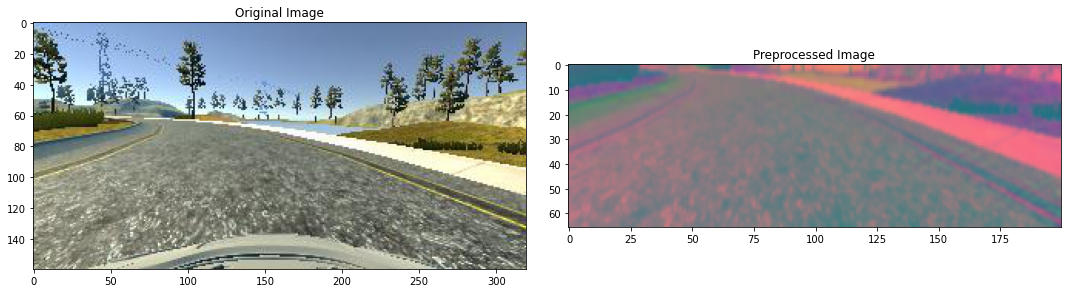

In [139]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [141]:
del list
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1259, 66, 200, 3)


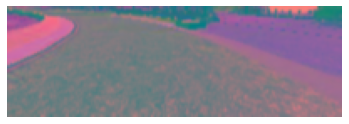

In [143]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)